<a href="https://colab.research.google.com/github/ahxlzjt/social-communication-enhancement-asd-expression-recognition/blob/main/social_communication_enhancement_asd_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import time

import torchvision
from torchvision import datasets, models, transforms

import PIL
import matplotlib.pyplot as plt
import os
import zipfile
from PIL import Image
import pandas as pd
import numpy as np

!pip install split-folders
import splitfolders

import cv2
import dlib
from torchvision.transforms import functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/2024-1 패턴인식과 머신러닝/Team Project 3조/data.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [ ]:
# rootdirectory 설정
root_dir = "/content/data/6 Emotions for image classification"

# rootdirectory안에 있는 데이터 저장
class_names = sorted(x for x in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, x))) # 클래스 이름
num_class = len(class_names) # 클래스 개수
image_files = [ # 각 클래스별 이미지 경로 리스트
    [os.path.join(root_dir, class_names[i], x) for x in os.listdir(os.path.join(root_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)] # 각 클래스별 이미지 개수
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i]) # 이미지 경로 리스트
    image_class.extend([i] * num_each[i]) # 이미지 라벨 리스트
num_total = len(image_class)   # 전체 이미지 개수
image_width, image_height = PIL.Image.open(image_files_list[0]).size # 이미지 사이즈 확인

data_dir = "data"
splitfolders.ratio(root_dir, data_dir, ratio=(.6,.2,.2),group_prefix=None) # train, val, test 데이터로 분할

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Copying files: 1200 files [00:00, 4997.55 files/s]

Total image count: 1200
Image dimensions: 390 x 280
Label names: ['anger', 'disgust', 'fear', 'happy', 'pain', 'sad']
Label counts: [214, 201, 163, 230, 168, 224]


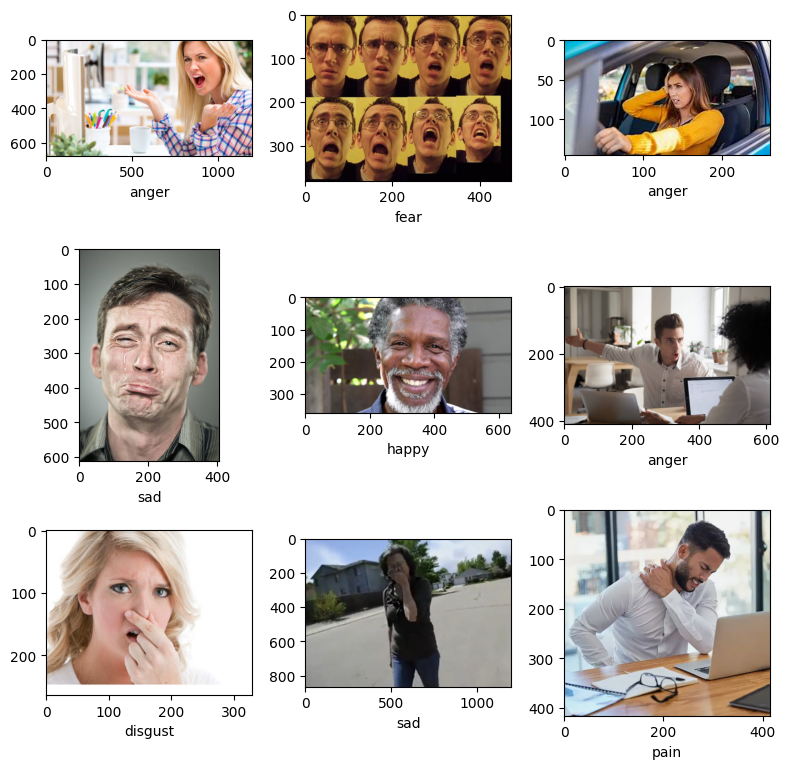

In [ ]:
# 이미지 출력
plt.subplots(3, 3, figsize=(8, 8)) # 3X3의 그림
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
# 얼굴 인식 함수 정의
detector = dlib.get_frontal_face_detector()
predictor_path = "/content/drive/MyDrive/2024-1 패턴인식과 머신러닝/Team Project 3조/shape_predictor_68_face_landmarks.dat" # 얼굴 이미지에서 68개의 점으로 특정 지점을 검출하기 위한 데이터
predictor = dlib.shape_predictor(predictor_path)

def detect_and_crop_face(image):
    img = np.array(image) # 이미지를 numpy 배열로 변환

    # 얼굴 탐지
    dets = detector(img, 1)
    if len(dets) > 0:
        d = dets[0] # 첫 번째 얼굴 영역 가져오기
        left, top, right, bottom = d.left(), d.top(), d.right(), d.bottom()
        # 얼굴 영역의 경계를 이미지 경계 안에 있는지 확인하여 예외 처리
        left = max(0, left)
        top = max(0, top)
        right = min(img.shape[1], right)
        bottom = min(img.shape[0], bottom)
        face = img[top:bottom, left:right] # 얼굴 영역을 크롭
        face_image = PIL.Image.fromarray(face) # 얼굴 영역을 PIL 이미지로 변환
        return face_image
    else:
        return image   # 얼굴을 찾지 못한 경우 원본 이미지를 반환


In [ ]:
# transformation 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(detect_and_crop_face),  # 얼굴 검출 및 크롭
        transforms.Resize((224, 224)),  # 사이즈 224x224로 재정의
        transforms.RandomHorizontalFlip(),  # 랜덤으로 좌우 반전
        transforms.RandomRotation(30),  # 랜덤으로 30도 회전
        transforms.RandomAffine(degrees=0, shear=0.1, scale=(0.9, 1.1)),  # 랜덤 어파인 변환
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 색상 변화
        transforms.RandomGrayscale(p=0.1),  # 10% 확률로 그레이스케일 변환
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 이미지 정규화
    ]),
    'val': transforms.Compose([
        transforms.Lambda(detect_and_crop_face),  # 얼굴 검출 및 크롭
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Lambda(detect_and_crop_face),  # 얼굴 검출 및 크롭
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 만들기
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

# 데이터로더 만들기
batch_size = 16
dataloaders = {x: torch.utils.data.DataLoader(
                    image_datasets[x],
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=8,
                    pin_memory=True) for x in ['train', 'val', 'test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']} # 데이터셋 크기
class_names = image_datasets['train'].classes # 클래스 이름

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용 가능 여부에 따라 device 정보 저장

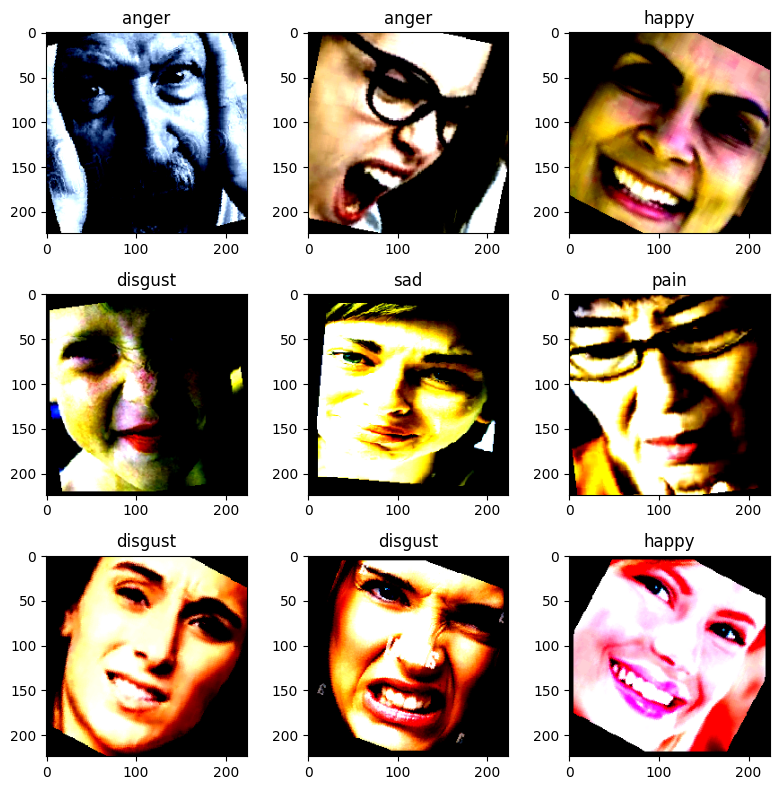

In [ ]:
# 전처리된 이미지 시각화

inputs, classes = next(iter(dataloaders['train'])) # 데이터 로더에서 배치 가져오기

# 예시 이미지 출력
plt.subplots(3, 3, figsize=(8, 8))  # 3X3의 그림
for i in range(9):  # 9개의 이미지만 출력
    image = inputs[i]
    inp = image.permute(1, 2, 0).numpy() # 이미지 텐서를 numpy 배열로 변환하여 이미지로 변환
    inp = np.clip(inp, 0, 1) # 이미지를 0과 1 사이의 값으로 정규화

    plt.subplot(3, 3, i + 1)
    plt.imshow(inp)
    plt.title(class_names[classes[i]], fontsize=12)

plt.tight_layout()
plt.show()

**[CNN Model]**

LeNet : First

AlexNet : ILSVRC 2012 winner (top-5 err. 16.4%)
- ReLu
- LRN
- Overlapping Pooling
- Dropout

ZFNet : ILSVRC 2013 winner

GoogleNet : ILSVRC 2014 winner

VGGNet : ILSVRC 2014 2nd place (top-5 err. 7.3%)

-> VGG16의 경우 ResNet50보다는 단순한 아키텍쳐임

resnet50 : ILSVRC 2015 winner  [수업시간에 사용]

Xception : 2016

SENet : ILSVRC 2017 winner

MobileNet : 2017

DenseNet : 2017

ShuffleNet : 2017

EfficientNet : 2018 / 파라미터 수는 적고, 정확도는 증가



In [ ]:
# 훈련, 검증, 테스트 데이터셋 크기 확인
print(f"Train dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Test dataset size: {dataset_sizes['test']}")


Train dataset size: 716
Validation dataset size: 237
Test dataset size: 245


### **1. CNN model 선정 - Loss function과 Optimizer는 고정(CELoss+Adam)**

In [ ]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

def train_model(model, model_name, loss_function, optimizer, scheduler, max_epochs):
    file_name = f"{model_name}_model_params.pt"
    best_acc = 0.0
    loss_dict = {"train": [], "val": []}
    acc_dict = {"train": [], "val": []}

    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1}/{max_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = loss_function(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc.item())

            plt.plot(range(len(loss_dict[phase])), loss_dict[phase])
            plt.savefig(f"{phase}_Loss.png")
            plt.close()

            plt.plot(range(len(acc_dict[phase])), acc_dict[phase])
            plt.savefig(f"{phase}_ACC.png")
            plt.close()

            print(f'{phase} Total Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), file_name)

            if phase == 'val':
                scheduler.step(epoch_loss)

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    torch.save(loss_dict, f"{model_name}_loss_dict.pth")
    torch.save(acc_dict, f"{model_name}_acc_dict.pth")

In [ ]:
loss_function = torch.nn.CrossEntropyLoss() # loss function 정의
max_epochs = 30 # epoch 수 정의

####**1. resnet50 (수업시간과 동일)**

In [ ]:
n_features = 6

model_1 = models.resnet50(pretrained=True)  # resnet50 모델 불러오기   # pretrained: 선학습된 데이터를 가지고 학습하겠다!
model_1.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_1.fc.in_features, n_features)  # 마지막 fully connected layer
)

model_1.to(device)   # 모델을 디바이스로 보내줘야 함 (CPU -> GPU)

model_1  # 모델 출력

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0)

In [ ]:
train_model(model_1, 'resnet50', loss_function, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 1.7776 Acc: 0.2221
val Total Loss: 1.7005 Acc: 0.3460

Epoch 2/30
----------
train Total Loss: 1.6713 Acc: 0.3226
val Total Loss: 1.6095 Acc: 0.4135

Epoch 3/30
----------
train Total Loss: 1.5593 Acc: 0.3813
val Total Loss: 1.4974 Acc: 0.4810

Epoch 4/30
----------
train Total Loss: 1.4300 Acc: 0.4874
val Total Loss: 1.3799 Acc: 0.5359

Epoch 5/30
----------
train Total Loss: 1.2805 Acc: 0.5419
val Total Loss: 1.2764 Acc: 0.5527

Epoch 6/30
----------
train Total Loss: 1.2130 Acc: 0.5768
val Total Loss: 1.1950 Acc: 0.5865

Epoch 7/30
----------
train Total Loss: 1.0887 Acc: 0.6369
val Total Loss: 1.1365 Acc: 0.5823

Epoch 8/30
----------
train Total Loss: 1.0220 Acc: 0.6578
val Total Loss: 1.0693 Acc: 0.6203

Epoch 9/30
----------
train Total Loss: 0.9426 Acc: 0.6927
val Total Loss: 1.0218 Acc: 0.6329

Epoch 10/30
----------
train Total Loss: 0.8429 Acc: 0.7388
val Total Loss: 0.9874 Acc: 0.6498

Epoch 11/30
----------
train Total Loss: 0.8194 A

####**2. LeNet-5**

https://stydy-sturdy.tistory.com/5 참고하였습니다!

In [ ]:
n_features = 6

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, 5, 1),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5, 1),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(16, 120, 5, 1),
            nn.Tanh(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 6),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model_2 = LeNet5()
model_2.to(device)  # 모델을 GPU 또는 CPU로 이동
model_2

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=6, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
train_model(model_2, 'LeNet5', loss_function, optimizer, scheduler , max_epochs)

Epoch 1/30
----------
train Total Loss: 1.7863 Acc: 0.1913
val Total Loss: 1.7894 Acc: 0.1899

Epoch 2/30
----------
train Total Loss: 1.7808 Acc: 0.1927
val Total Loss: 1.7860 Acc: 0.1899

Epoch 3/30
----------
train Total Loss: 1.7771 Acc: 0.1927
val Total Loss: 1.7833 Acc: 0.1941

Epoch 4/30
----------
train Total Loss: 1.7731 Acc: 0.1969
val Total Loss: 1.7800 Acc: 0.1941

Epoch 5/30
----------
train Total Loss: 1.7705 Acc: 0.2011
val Total Loss: 1.7768 Acc: 0.2025

Epoch 6/30
----------
train Total Loss: 1.7656 Acc: 0.2151
val Total Loss: 1.7750 Acc: 0.1941

Epoch 7/30
----------
train Total Loss: 1.7606 Acc: 0.2151
val Total Loss: 1.7724 Acc: 0.2025

Epoch 8/30
----------
train Total Loss: 1.7568 Acc: 0.2235
val Total Loss: 1.7703 Acc: 0.2025

Epoch 9/30
----------
train Total Loss: 1.7554 Acc: 0.2207
val Total Loss: 1.7687 Acc: 0.2025

Epoch 10/30
----------
train Total Loss: 1.7507 Acc: 0.2249
val Total Loss: 1.7664 Acc: 0.2110

Epoch 11/30
----------
train Total Loss: 1.7452 A

####**3. AlexNet**

In [ ]:
n_features = 6

model_3 = models.alexnet(pretrained=True)
model_3.classifier[6] = nn.Linear(model_3.classifier[6].in_features, n_features)
model_3.to(device)   # 모델을 디바이스로 보내줘야 함 (CPU -> GPU)

optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

train_model(model_3, 'AlexNet', loss_function, optimizer, scheduler, max_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 184MB/s]


Epoch 1/30
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


train Total Loss: 1.8471 Acc: 0.1774
val Total Loss: 1.6877 Acc: 0.2827

Epoch 2/30
----------
train Total Loss: 1.6391 Acc: 0.3184
val Total Loss: 1.5758 Acc: 0.3671

Epoch 3/30
----------
train Total Loss: 1.5088 Acc: 0.4022
val Total Loss: 1.4813 Acc: 0.4135

Epoch 4/30
----------
train Total Loss: 1.4292 Acc: 0.4232
val Total Loss: 1.3969 Acc: 0.4473

Epoch 5/30
----------
train Total Loss: 1.3403 Acc: 0.4791
val Total Loss: 1.3276 Acc: 0.4684

Epoch 6/30
----------
train Total Loss: 1.2350 Acc: 0.5209
val Total Loss: 1.2885 Acc: 0.4852

Epoch 7/30
----------
train Total Loss: 1.1569 Acc: 0.5642
val Total Loss: 1.2208 Acc: 0.5359

Epoch 8/30
----------
train Total Loss: 1.0686 Acc: 0.5978
val Total Loss: 1.1798 Acc: 0.5274

Epoch 9/30
----------
train Total Loss: 1.0250 Acc: 0.6411
val Total Loss: 1.1495 Acc: 0.5527

Epoch 10/30
----------
train Total Loss: 1.0037 Acc: 0.6159
val Total Loss: 1.1238 Acc: 0.5485

Epoch 11/30
----------
train Total Loss: 0.9414 Acc: 0.6355
val Total L

####**4. Vggnet**

In [ ]:
n_features = 6
model_4 = models.vgg16(pretrained=True)
num_features = model_4.classifier[6].in_features
model_4.classifier[6] = nn.Linear(num_features, n_features)
model_4.to(device)
optimizer = torch.optim.Adam(model_4.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
train_model(model_4, 'Vggnet', loss_function, optimizer,scheduler,max_epochs)

Epoch 1/30
----------
train Total Loss: 1.8211 Acc: 0.1816
val Total Loss: 1.7467 Acc: 0.2447

Epoch 2/30
----------
train Total Loss: 1.6577 Acc: 0.2933
val Total Loss: 1.6587 Acc: 0.3207

Epoch 3/30
----------
train Total Loss: 1.5209 Acc: 0.3729
val Total Loss: 1.4975 Acc: 0.3966

Epoch 4/30
----------
train Total Loss: 1.3771 Acc: 0.4469
val Total Loss: 1.4127 Acc: 0.4262

Epoch 5/30
----------
train Total Loss: 1.2438 Acc: 0.4888
val Total Loss: 1.2648 Acc: 0.5570

Epoch 6/30
----------
train Total Loss: 1.1461 Acc: 0.5698
val Total Loss: 1.1398 Acc: 0.6160

Epoch 7/30
----------
train Total Loss: 0.9809 Acc: 0.6229
val Total Loss: 1.1187 Acc: 0.6118

Epoch 8/30
----------
train Total Loss: 0.9387 Acc: 0.6411
val Total Loss: 1.0430 Acc: 0.6414

Epoch 9/30
----------
train Total Loss: 0.8138 Acc: 0.7025
val Total Loss: 1.0643 Acc: 0.6414

Epoch 10/30
----------
train Total Loss: 0.7665 Acc: 0.7095
val Total Loss: 1.0180 Acc: 0.6667

Epoch 11/30
----------
train Total Loss: 0.7326 A

####**5. SEnet**

In [ ]:
n_features = 6
model_5 = models.squeezenet1_0(pretrained=True)
model_5.classifier[1] = nn.Conv2d(512, n_features, kernel_size=1)
model_5.to(device)
optimizer = torch.optim.Adam(model_5.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
train_model(model_5, 'SEnet', loss_function, optimizer, scheduler, max_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 119MB/s]

Epoch 1/30
----------


train Total Loss: 1.8894 Acc: 0.2165
val Total Loss: 1.8262 Acc: 0.2616

Epoch 2/30
----------
train Total Loss: 1.7244 Acc: 0.2849
val Total Loss: 1.7632 Acc: 0.2616

Epoch 3/30
----------
train Total Loss: 1.6838 Acc: 0.2835
val Total Loss: 1.7266 Acc: 0.2785

Epoch 4/30
----------
train Total Loss: 1.6398 Acc: 0.3366
val Total Loss: 1.6594 Acc: 0.2827

Epoch 5/30
----------
train Total Loss: 1.5820 Acc: 0.3464
val Total Loss: 1.6181 Acc: 0.3249

Epoch 6/30
----------
train Total Loss: 1.5287 Acc: 0.3953
val Total Loss: 1.5440 Acc: 0.3629

Epoch 7/30
----------
train Total Loss: 1.4782 Acc: 0.4288
val Total Loss: 1.4776 Acc: 0.3797

Epoch 8/30
----------
train Total Loss: 1.4252 Acc: 0.4316
val Total Loss: 1.4569 Acc: 0.4473

Epoch 9/30
----------
train Total Loss: 1.3852 Acc: 0.4693
val Total Loss: 1.4595 Acc: 0.4430

Epoch 10/30
----------
train Total Loss: 1.3427 Acc: 0.4846
val Total Loss: 1.4041 Acc: 0.4599

Epoch 11/30
----------
train Total Loss: 1.3126 Acc: 0.4930
val Total L

####**6. effiecientNet**

In [ ]:
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
n_features = 6

model_6 = timm.create_model("efficientnet_b4", pretrained=True) #pretrained : 선학습된 데이터를 가지고 학습하겠다!
model_6.classifier = nn.Linear(model_6.classifier.in_features, n_features) # layer를 변경하여 출력 크기를 10으로 변경!
model_6.to(device)

optimizer = torch.optim.Adam(model_6.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

train_model(model_6, 'EfficientNet', loss_function, optimizer, scheduler, max_epochs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Epoch 1/30
----------
train Total Loss: 1.7975 Acc: 0.1592
val Total Loss: 1.7982 Acc: 0.1730

Epoch 2/30
----------
train Total Loss: 1.7867 Acc: 0.1941
val Total Loss: 1.7934 Acc: 0.1730

Epoch 3/30
----------
train Total Loss: 1.7823 Acc: 0.2123
val Total Loss: 1.7875 Acc: 0.1814

Epoch 4/30
----------
train Total Loss: 1.7683 Acc: 0.2500
val Total Loss: 1.7823 Acc: 0.1772

Epoch 5/30
----------
train Total Loss: 1.7632 Acc: 0.2709
val Total Loss: 1.7780 Acc: 0.2236

Epoch 6/30
----------
train Total Loss: 1.7575 Acc: 0.2849
val Total Loss: 1.7708 Acc: 0.2489

Epoch 7/30
----------
train Total Loss: 1.7489 Acc: 0.3101
val Total Loss: 1.7659 Acc: 0.2658

Epoch 8/30
----------
train Total Loss: 1.7448 Acc: 0.3003
val Total Loss: 1.7581 Acc: 0.2911

Epoch 9/30
----------
train Total Loss: 1.7324 Acc: 0.3506
val Total Loss: 1.7534 Acc: 0.2911

Epoch 10/30
----------
train Total Loss: 1.7195 Acc: 0.3715
val Total Loss: 1.7472 Acc: 0.3249

Epoch 11/30
----------
train Total Loss: 1.7116 A

####**7. Densenet**

In [ ]:
import timm

n_features = 6

# DenseNet 모델 정의
model_7 = timm.create_model("densenet121", pretrained=True) # pretrained: 선학습된 데이터를 사용
model_7.classifier = nn.Linear(model_7.classifier.in_features, n_features) # 출력 크기를 6으로 변경
model_7.to(device)

optimizer = torch.optim.Adam(model_7.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

train_model(model_7, 'Densenet', loss_function, optimizer, scheduler, max_epochs)

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Epoch 1/30
----------
train Total Loss: 1.8343 Acc: 0.1732
val Total Loss: 1.8369 Acc: 0.1814

Epoch 2/30
----------
train Total Loss: 1.7673 Acc: 0.2277
val Total Loss: 1.8004 Acc: 0.2194

Epoch 3/30
----------
train Total Loss: 1.7239 Acc: 0.2668
val Total Loss: 1.7714 Acc: 0.2489

Epoch 4/30
----------
train Total Loss: 1.6839 Acc: 0.3170
val Total Loss: 1.7350 Acc: 0.2616

Epoch 5/30
----------
train Total Loss: 1.6559 Acc: 0.3254
val Total Loss: 1.7110 Acc: 0.2996

Epoch 6/30
----------
train Total Loss: 1.6280 Acc: 0.3715
val Total Loss: 1.6833 Acc: 0.3080

Epoch 7/30
----------
train Total Loss: 1.5878 Acc: 0.3980
val Total Loss: 1.6536 Acc: 0.3291

Epoch 8/30
----------
train Total Loss: 1.5429 Acc: 0.4413
val Total Loss: 1.6255 Acc: 0.3671

Epoch 9/30
----------
train Total Loss: 1.4942 Acc: 0.4902
val Total Loss: 1.6002 Acc: 0.3671

Epoch 10/30
----------
train Total Loss: 1.4616 Acc: 0.4958
val Total Loss: 1.5650 Acc: 0.3713

Epoch 11/30
----------
train Total Loss: 1.4419 A

####**8.resnet152**

In [ ]:
n_features = 6

model_8 = models.resnet152(pretrained=True)
model_8.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model_8.fc.in_features, n_features)
)
model_8.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 237MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
optimizer = torch.optim.Adam(model_8.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [ ]:
train_model(model_8, 'resnet152', loss_function, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 1.8116 Acc: 0.1760
val Total Loss: 1.7004 Acc: 0.2658

Epoch 2/30
----------
train Total Loss: 1.6451 Acc: 0.3073
val Total Loss: 1.5806 Acc: 0.3755

Epoch 3/30
----------
train Total Loss: 1.5197 Acc: 0.4204
val Total Loss: 1.4662 Acc: 0.4768

Epoch 4/30
----------
train Total Loss: 1.4034 Acc: 0.4777
val Total Loss: 1.3223 Acc: 0.5612

Epoch 5/30
----------
train Total Loss: 1.2547 Acc: 0.5587
val Total Loss: 1.2272 Acc: 0.5738

Epoch 6/30
----------
train Total Loss: 1.1408 Acc: 0.5964
val Total Loss: 1.0947 Acc: 0.6245

Epoch 7/30
----------
train Total Loss: 0.9947 Acc: 0.6634
val Total Loss: 1.0161 Acc: 0.6287

Epoch 8/30
----------
train Total Loss: 0.9003 Acc: 0.6983
val Total Loss: 0.9465 Acc: 0.6709

Epoch 9/30
----------
train Total Loss: 0.8060 Acc: 0.7207
val Total Loss: 0.9103 Acc: 0.6793

Epoch 10/30
----------
train Total Loss: 0.7302 Acc: 0.7696
val Total Loss: 0.8801 Acc: 0.6667

Epoch 11/30
----------
train Total Loss: 0.6696 A

####**model_1~8 Evaluation**

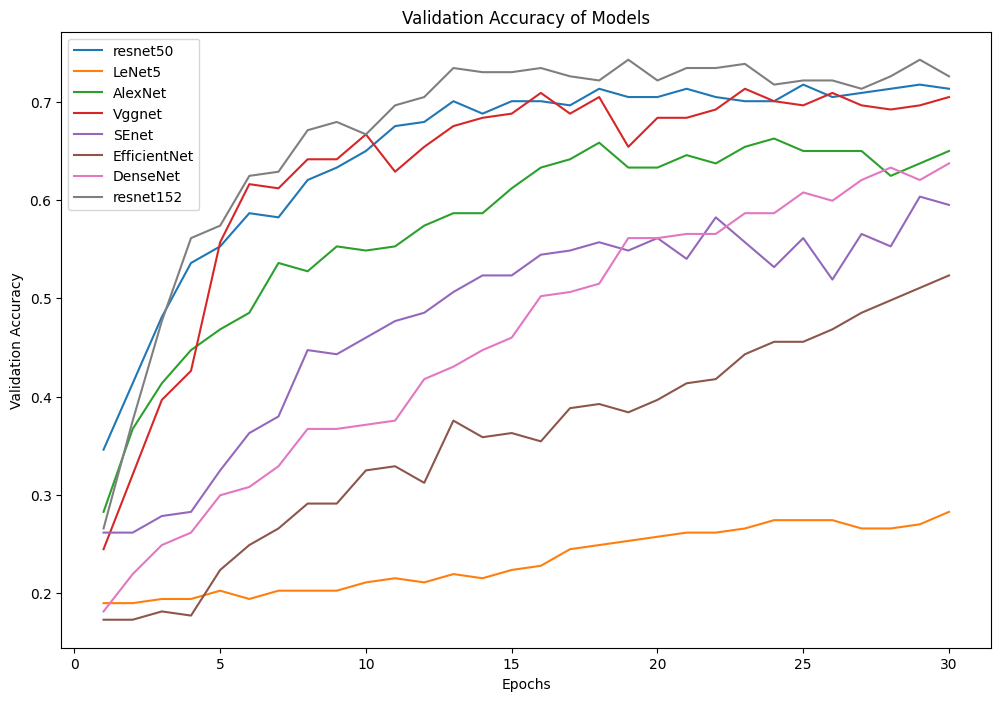

In [ ]:
plt.figure(figsize=(12, 8))

resnet50_acc_dict = torch.load("/content/resnet50_acc_dict.pth")
plt.plot(range(1, len(resnet50_acc_dict['val']) + 1), resnet50_acc_dict['val'], label='resnet50')

LeNet5_acc_dict = torch.load("/content/LeNet5_acc_dict.pth")
plt.plot(range(1, len(LeNet5_acc_dict['val']) + 1), LeNet5_acc_dict['val'], label='LeNet5')

AlexNet_acc_dict = torch.load("/content/AlexNet_acc_dict.pth")
plt.plot(range(1, len(AlexNet_acc_dict['val']) + 1), AlexNet_acc_dict['val'], label='AlexNet')

Vggnet_acc_dict = torch.load("/content/Vggnet_acc_dict.pth")
plt.plot(range(1, len(Vggnet_acc_dict['val']) + 1), Vggnet_acc_dict['val'], label='Vggnet')

SEnet_acc_dict = torch.load("/content/SEnet_acc_dict.pth")
plt.plot(range(1, len(SEnet_acc_dict['val']) + 1), SEnet_acc_dict['val'], label='SEnet')

EfficientNet_acc_dict = torch.load("/content/EfficientNet_acc_dict.pth")
plt.plot(range(1, len(EfficientNet_acc_dict['val']) + 1), EfficientNet_acc_dict['val'], label='EfficientNet')

DenseNet_acc_dict = torch.load("/content/Densenet_acc_dict.pth")
plt.plot(range(1, len(DenseNet_acc_dict['val']) + 1), DenseNet_acc_dict['val'], label='DenseNet')

resnet152_acc_dict = torch.load("/content/resnet152_acc_dict.pth")
plt.plot(range(1, len(resnet152_acc_dict['val']) + 1), resnet152_acc_dict['val'], label='resnet152')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy of Models')
plt.savefig('validation_accuracy.png')
plt.show()


In [ ]:
model_best=model_8

### **2. Loss function 선정 - Optimizer는 고정(Adam)**

**[Loss function]**

CrossEntropyLoss : 다중 클래스 분류 / LogSoftmax 포함 (LogSoftmax+NLLLoss)
BCELoss : 이진분류

MSELoss : 회귀모델 사용

NLLLoss : LogSoftmax 포함X

MultiMarginLoss : 다중 클래스 분류 , 각 클래스에 대한 마진 최대화

In [ ]:
loss_function_1 = nn.CrossEntropyLoss()
loss_function_2 = nn.MSELoss()
loss_function_3 = nn.MultiLabelSoftMarginLoss()
loss_function_4 = nn.MultiMarginLoss()

In [ ]:
n_features = 6

model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.Adam(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
train_model(model_best, 'CEloss', loss_function_1, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 1.8034 Acc: 0.2179
val Total Loss: 1.7040 Acc: 0.3376

Epoch 2/30
----------
train Total Loss: 1.6990 Acc: 0.3045
val Total Loss: 1.6106 Acc: 0.4430

Epoch 3/30
----------
train Total Loss: 1.5850 Acc: 0.3869
val Total Loss: 1.4929 Acc: 0.5063

Epoch 4/30
----------
train Total Loss: 1.4202 Acc: 0.4721
val Total Loss: 1.3470 Acc: 0.5570

Epoch 5/30
----------
train Total Loss: 1.2608 Acc: 0.5642
val Total Loss: 1.2121 Acc: 0.5865

Epoch 6/30
----------
train Total Loss: 1.1237 Acc: 0.6355
val Total Loss: 1.1109 Acc: 0.6414

Epoch 7/30
----------
train Total Loss: 1.0558 Acc: 0.6397
val Total Loss: 1.0447 Acc: 0.6414

Epoch 8/30
----------
train Total Loss: 0.9261 Acc: 0.6983
val Total Loss: 0.9704 Acc: 0.6329

Epoch 9/30
----------
train Total Loss: 0.8581 Acc: 0.7346
val Total Loss: 0.9156 Acc: 0.6793

Epoch 10/30
----------
train Total Loss: 0.7568 Acc: 0.7626
val Total Loss: 0.8833 Acc: 0.6793

Epoch 11/30
----------
train Total Loss: 0.6533 A

In [ ]:
from torch.nn.functional import one_hot

def train_model_one(model, model_name, loss_function, optimizer, scheduler, max_epochs):
    file_name = f"{model_name}_model_params.pt"
    best_acc = 0.0
    loss_dict = {"train": [], "val": []}
    acc_dict = {"train": [], "val": []}

    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1}/{max_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)

                        # 레이블을 원-핫 인코딩하여 손실 함수에 전달
                        labels_one_hot = one_hot(labels, num_classes=n_features).float()
                        loss = loss_function(outputs, labels_one_hot)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc.item())

            plt.plot(range(len(loss_dict[phase])), loss_dict[phase])
            plt.savefig(f"{phase}_Loss.png")
            plt.close()

            plt.plot(range(len(acc_dict[phase])), acc_dict[phase])
            plt.savefig(f"{phase}_ACC.png")
            plt.close()

            print(f'{phase} Total Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), file_name)

            if phase == 'val':
                scheduler.step(epoch_loss)

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    torch.save(loss_dict, f"{model_name}_loss_dict.pth")
    torch.save(acc_dict, f"{model_name}_acc_dict.pth")

-> 입력의 크기가 [16,6]이므로 레이블을 해당 클래스 수로 인코딩해야함 '원핫 인코딩' 추가

In [ ]:
n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.Adam(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
train_model_one(model_best, 'MSELoss', loss_function_2, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 0.3047 Acc: 0.1941
val Total Loss: 0.1709 Acc: 0.2321

Epoch 2/30
----------
train Total Loss: 0.2430 Acc: 0.2430
val Total Loss: 0.1499 Acc: 0.3165

Epoch 3/30
----------
train Total Loss: 0.2452 Acc: 0.2346
val Total Loss: 0.1372 Acc: 0.3840

Epoch 4/30
----------
train Total Loss: 0.2212 Acc: 0.2891
val Total Loss: 0.1297 Acc: 0.4219

Epoch 5/30
----------
train Total Loss: 0.2102 Acc: 0.3436
val Total Loss: 0.1235 Acc: 0.4515

Epoch 6/30
----------
train Total Loss: 0.2017 Acc: 0.3729
val Total Loss: 0.1174 Acc: 0.4979

Epoch 7/30
----------
train Total Loss: 0.1985 Acc: 0.3659
val Total Loss: 0.1128 Acc: 0.5274

Epoch 8/30
----------
train Total Loss: 0.1800 Acc: 0.4316
val Total Loss: 0.1111 Acc: 0.5274

Epoch 9/30
----------
train Total Loss: 0.1689 Acc: 0.4204
val Total Loss: 0.1071 Acc: 0.5527

Epoch 10/30
----------
train Total Loss: 0.1581 Acc: 0.4944
val Total Loss: 0.1071 Acc: 0.5654

Epoch 11/30
----------
train Total Loss: 0.1596 A

In [ ]:
n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.Adam(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_model_one(model_best, 'MultiLabelSoftMarginLoss', loss_function_3, optimizer, scheduler, max_epochs)


Epoch 1/30
----------
train Total Loss: 0.6508 Acc: 0.1885
val Total Loss: 0.5853 Acc: 0.2785

Epoch 2/30
----------
train Total Loss: 0.5488 Acc: 0.2458
val Total Loss: 0.5110 Acc: 0.3418

Epoch 3/30
----------
train Total Loss: 0.4818 Acc: 0.3184
val Total Loss: 0.4589 Acc: 0.4304

Epoch 4/30
----------
train Total Loss: 0.4342 Acc: 0.3980
val Total Loss: 0.4166 Acc: 0.5148

Epoch 5/30
----------
train Total Loss: 0.3968 Acc: 0.5056
val Total Loss: 0.3811 Acc: 0.5907

Epoch 6/30
----------
train Total Loss: 0.3650 Acc: 0.5866
val Total Loss: 0.3516 Acc: 0.6287

Epoch 7/30
----------
train Total Loss: 0.3300 Acc: 0.6271
val Total Loss: 0.3233 Acc: 0.6371

Epoch 8/30
----------
train Total Loss: 0.3074 Acc: 0.6578
val Total Loss: 0.3002 Acc: 0.6540

Epoch 9/30
----------
train Total Loss: 0.2819 Acc: 0.7179
val Total Loss: 0.2872 Acc: 0.6624

Epoch 10/30
----------
train Total Loss: 0.2617 Acc: 0.7402
val Total Loss: 0.2687 Acc: 0.6793

Epoch 11/30
----------
train Total Loss: 0.2374 A

In [ ]:
n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.Adam(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [ ]:
train_model(model_best, 'MultiMarginLoss', loss_function_4, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 0.7744 Acc: 0.2137
val Total Loss: 0.7144 Acc: 0.2489

Epoch 2/30
----------
train Total Loss: 0.6704 Acc: 0.2584
val Total Loss: 0.6137 Acc: 0.3249

Epoch 3/30
----------
train Total Loss: 0.5727 Acc: 0.3450
val Total Loss: 0.5256 Acc: 0.4051

Epoch 4/30
----------
train Total Loss: 0.4968 Acc: 0.4497
val Total Loss: 0.4545 Acc: 0.5063

Epoch 5/30
----------
train Total Loss: 0.3759 Acc: 0.5405
val Total Loss: 0.3910 Acc: 0.5907

Epoch 6/30
----------
train Total Loss: 0.3464 Acc: 0.5615
val Total Loss: 0.3533 Acc: 0.6203

Epoch 7/30
----------
train Total Loss: 0.3074 Acc: 0.5992
val Total Loss: 0.3244 Acc: 0.6456

Epoch 8/30
----------
train Total Loss: 0.2829 Acc: 0.6453
val Total Loss: 0.2985 Acc: 0.6624

Epoch 9/30
----------
train Total Loss: 0.2290 Acc: 0.6941
val Total Loss: 0.2846 Acc: 0.6878

Epoch 10/30
----------
train Total Loss: 0.2122 Acc: 0.6955
val Total Loss: 0.2766 Acc: 0.7131

Epoch 11/30
----------
train Total Loss: 0.1938 A

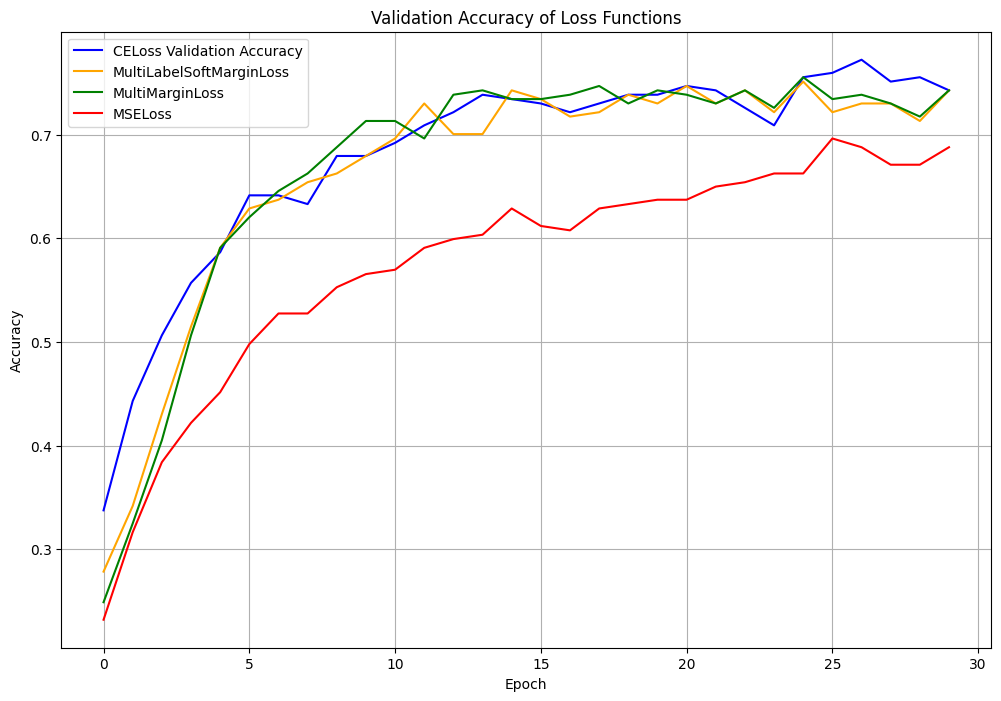

In [ ]:
import torch
import matplotlib.pyplot as plt

ce_acc_dict = torch.load("CEloss_acc_dict.pth")
multi_label_soft_margin_loss_acc_dict = torch.load("MultiLabelSoftMarginLoss_acc_dict.pth")
multi_margin_loss_acc_dict = torch.load("MultiMarginLoss_acc_dict.pth")
mse_loss_acc_dict = torch.load("MSELoss_acc_dict.pth")

plt.figure(figsize=(12, 8))

plt.plot(range(len(ce_acc_dict['val'])), ce_acc_dict['val'], label='CELoss Validation Accuracy', color='blue')
plt.plot(range(len(multi_label_soft_margin_loss_acc_dict['val'])), multi_label_soft_margin_loss_acc_dict['val'], label='MultiLabelSoftMarginLoss', color='orange')
plt.plot(range(len(multi_margin_loss_acc_dict['val'])), multi_margin_loss_acc_dict['val'], label='MultiMarginLoss', color='green')
plt.plot(range(len(mse_loss_acc_dict['val'])), mse_loss_acc_dict['val'], label='MSELoss', color='red')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy of Loss Functions')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
loss_function_best=loss_function_1

### **3. Optimizer 선정**

**[Optimizer]**

Adam [수업시간에 사용]

Rmsprop : grad^2의 이동 평균을 이용하여 학습률 조절

SGD : 기본 / 각각 parameter에 learning rate 곱함

Ranger -> 사용!

In [ ]:
!pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
#optimizer1 : adam

n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.Adam(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
train_model(model_best, 'Adam', loss_function_best, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 1.7982 Acc: 0.1955
val Total Loss: 1.6792 Acc: 0.3122

Epoch 2/30
----------
train Total Loss: 1.6775 Acc: 0.2933
val Total Loss: 1.5771 Acc: 0.4388

Epoch 3/30
----------
train Total Loss: 1.5279 Acc: 0.4134
val Total Loss: 1.4554 Acc: 0.5232

Epoch 4/30
----------
train Total Loss: 1.3964 Acc: 0.5070
val Total Loss: 1.3229 Acc: 0.5485

Epoch 5/30
----------
train Total Loss: 1.2505 Acc: 0.5559
val Total Loss: 1.2255 Acc: 0.5781

Epoch 6/30
----------
train Total Loss: 1.1380 Acc: 0.6034
val Total Loss: 1.1321 Acc: 0.6160

Epoch 7/30
----------
train Total Loss: 1.0169 Acc: 0.6592
val Total Loss: 1.0407 Acc: 0.6456

Epoch 8/30
----------
train Total Loss: 0.9153 Acc: 0.7067
val Total Loss: 0.9853 Acc: 0.6456

Epoch 9/30
----------
train Total Loss: 0.8204 Acc: 0.7458
val Total Loss: 0.9412 Acc: 0.6582

Epoch 10/30
----------
train Total Loss: 0.7339 Acc: 0.7612
val Total Loss: 0.8912 Acc: 0.6878

Epoch 11/30
----------
train Total Loss: 0.6650 A

In [ ]:
#optimizer2 : Adagrad

n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.Adagrad(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [ ]:
train_model(model_best, 'Adagrad', loss_function_best, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 1.8542 Acc: 0.1690
val Total Loss: 1.7986 Acc: 0.2068

Epoch 2/30
----------
train Total Loss: 1.8090 Acc: 0.1983
val Total Loss: 1.7864 Acc: 0.2152

Epoch 3/30
----------
train Total Loss: 1.8267 Acc: 0.1844
val Total Loss: 1.7702 Acc: 0.2278

Epoch 4/30
----------
train Total Loss: 1.8057 Acc: 0.1858
val Total Loss: 1.7649 Acc: 0.2321

Epoch 5/30
----------
train Total Loss: 1.7948 Acc: 0.2067
val Total Loss: 1.7577 Acc: 0.2363

Epoch 6/30
----------
train Total Loss: 1.7729 Acc: 0.2277
val Total Loss: 1.7509 Acc: 0.2405

Epoch 7/30
----------
train Total Loss: 1.7796 Acc: 0.2291
val Total Loss: 1.7479 Acc: 0.2363

Epoch 8/30
----------
train Total Loss: 1.7573 Acc: 0.2444
val Total Loss: 1.7384 Acc: 0.2574

Epoch 9/30
----------
train Total Loss: 1.7642 Acc: 0.2193
val Total Loss: 1.7316 Acc: 0.2616

Epoch 10/30
----------
train Total Loss: 1.7334 Acc: 0.2737
val Total Loss: 1.7258 Acc: 0.2574

Epoch 11/30
----------
train Total Loss: 1.7478 A

In [ ]:
#optimizer3 : RMSprop

n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.RMSprop(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [ ]:
train_model(model_best, 'RMSprop', loss_function_best, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 1.7000 Acc: 0.3017
val Total Loss: 1.5218 Acc: 0.4557

Epoch 2/30
----------
train Total Loss: 1.4129 Acc: 0.4888
val Total Loss: 1.3145 Acc: 0.5359

Epoch 3/30
----------
train Total Loss: 1.2176 Acc: 0.5922
val Total Loss: 1.1756 Acc: 0.5949

Epoch 4/30
----------
train Total Loss: 1.0947 Acc: 0.6271
val Total Loss: 1.0721 Acc: 0.6414

Epoch 5/30
----------
train Total Loss: 0.9593 Acc: 0.6955
val Total Loss: 0.9979 Acc: 0.6878

Epoch 6/30
----------
train Total Loss: 0.8710 Acc: 0.7207
val Total Loss: 0.9413 Acc: 0.6835

Epoch 7/30
----------
train Total Loss: 0.7878 Acc: 0.7514
val Total Loss: 0.9340 Acc: 0.7089

Epoch 8/30
----------
train Total Loss: 0.7130 Acc: 0.7696
val Total Loss: 0.8887 Acc: 0.7173

Epoch 9/30
----------
train Total Loss: 0.5852 Acc: 0.8170
val Total Loss: 0.8617 Acc: 0.7215

Epoch 10/30
----------
train Total Loss: 0.5675 Acc: 0.8254
val Total Loss: 0.8068 Acc: 0.7426

Epoch 11/30
----------
train Total Loss: 0.4751 A

In [ ]:
#optimizer4 : SGD

n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.SGD(model_best.parameters(), lr=1e-5, momentum=0.9) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [ ]:
train_model(model_best, 'SGD', loss_function_best, optimizer, scheduler, max_epochs)

Epoch 1/30
----------
train Total Loss: 1.8688 Acc: 0.1564
val Total Loss: 1.7974 Acc: 0.1983

Epoch 2/30
----------
train Total Loss: 1.8541 Acc: 0.1578
val Total Loss: 1.7883 Acc: 0.2068

Epoch 3/30
----------
train Total Loss: 1.8265 Acc: 0.1899
val Total Loss: 1.7783 Acc: 0.2405

Epoch 4/30
----------
train Total Loss: 1.8181 Acc: 0.1844
val Total Loss: 1.7755 Acc: 0.2321

Epoch 5/30
----------
train Total Loss: 1.8237 Acc: 0.1997
val Total Loss: 1.7665 Acc: 0.2532

Epoch 6/30
----------
train Total Loss: 1.8137 Acc: 0.1899
val Total Loss: 1.7631 Acc: 0.2616

Epoch 7/30
----------
train Total Loss: 1.7989 Acc: 0.1997
val Total Loss: 1.7553 Acc: 0.2785

Epoch 8/30
----------
train Total Loss: 1.7999 Acc: 0.2235
val Total Loss: 1.7515 Acc: 0.2658

Epoch 9/30
----------
train Total Loss: 1.8061 Acc: 0.2039
val Total Loss: 1.7502 Acc: 0.2616

Epoch 10/30
----------
train Total Loss: 1.8022 Acc: 0.1941
val Total Loss: 1.7432 Acc: 0.2700

Epoch 11/30
----------
train Total Loss: 1.7842 A

In [ ]:
#optimizer5 : Ranger

from torch_optimizer import Ranger

n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = Ranger(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [ ]:
train_model(model_best, 'Ranger', loss_function_best, optimizer, scheduler4, max_epochs)

Epoch 1/30
----------


/usr/local/lib/python3.10/dist-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


train Total Loss: 1.9239 Acc: 0.1606
val Total Loss: 1.8629 Acc: 0.1814

Epoch 2/30
----------
train Total Loss: 1.9098 Acc: 0.1648
val Total Loss: 1.8504 Acc: 0.1814

Epoch 3/30
----------
train Total Loss: 1.8817 Acc: 0.1676
val Total Loss: 1.8287 Acc: 0.1857

Epoch 4/30
----------
train Total Loss: 1.8620 Acc: 0.1760
val Total Loss: 1.8067 Acc: 0.1814

Epoch 5/30
----------
train Total Loss: 1.8441 Acc: 0.1788
val Total Loss: 1.7841 Acc: 0.1899

Epoch 6/30
----------
train Total Loss: 1.8105 Acc: 0.1746
val Total Loss: 1.7646 Acc: 0.1983

Epoch 7/30
----------
train Total Loss: 1.7876 Acc: 0.2207
val Total Loss: 1.7357 Acc: 0.2110

Epoch 8/30
----------
train Total Loss: 1.7482 Acc: 0.2416
val Total Loss: 1.7196 Acc: 0.2236

Epoch 9/30
----------
train Total Loss: 1.7287 Acc: 0.2430
val Total Loss: 1.6911 Acc: 0.2447

Epoch 10/30
----------
train Total Loss: 1.6811 Acc: 0.2765
val Total Loss: 1.6651 Acc: 0.2700

Epoch 11/30
----------
train Total Loss: 1.6633 Acc: 0.2947
val Total L

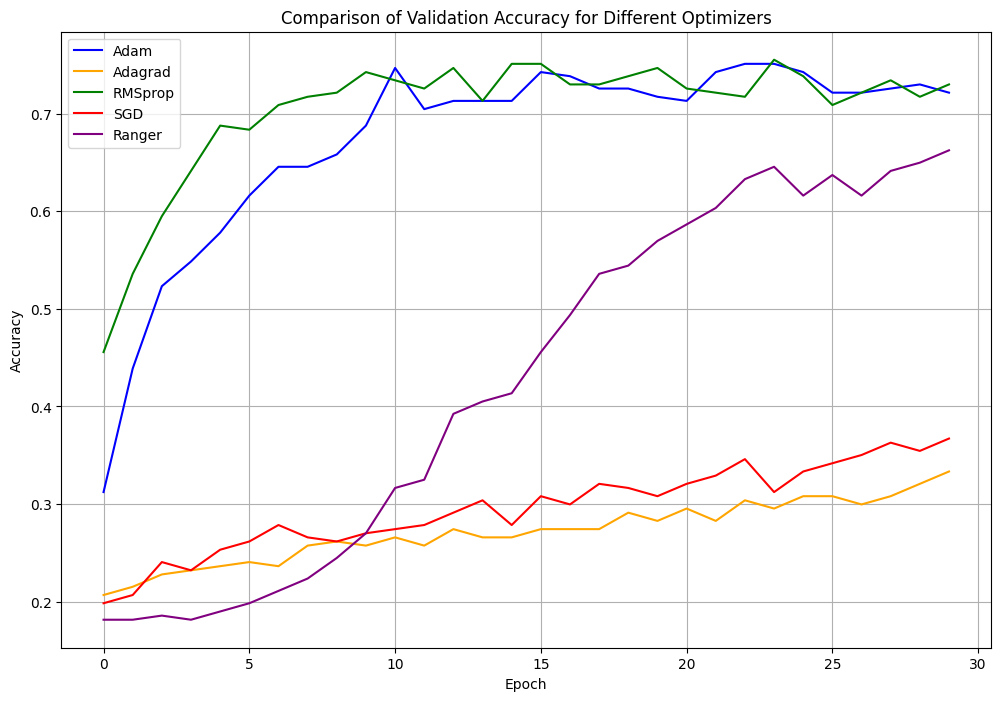

In [ ]:
import matplotlib.pyplot as plt
import torch

# 정확도 파일 불러오기
adam_acc_dict = torch.load("Adam_acc_dict.pth")
adagrad_acc_dict = torch.load("Adagrad_acc_dict.pth")
rmsprop_acc_dict = torch.load("RMSprop_acc_dict.pth")
sgd_acc_dict = torch.load("SGD_acc_dict.pth")
ranger_acc_dict = torch.load("Ranger_acc_dict.pth")

# 그래프 그리기
plt.figure(figsize=(12, 8))

# Validation Accuracy 그래프
plt.plot(range(len(adam_acc_dict['val'])), adam_acc_dict['val'], label='Adam', color='blue')
plt.plot(range(len(adagrad_acc_dict['val'])), adagrad_acc_dict['val'], label='Adagrad', color='orange')
plt.plot(range(len(rmsprop_acc_dict['val'])), rmsprop_acc_dict['val'], label='RMSprop', color='green')
plt.plot(range(len(sgd_acc_dict['val'])), sgd_acc_dict['val'], label='SGD', color='red')
plt.plot(range(len(ranger_acc_dict['val'])), ranger_acc_dict['val'], label='Ranger', color='purple')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison of Validation Accuracy for Different Optimizers')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
optimizer_best=torch.optim.RMSprop(model_best.parameters(), lr=1e-5)

In [ ]:
#최종 best model : resnet152 + CELoss + RMSprop
##최종 best model 전체 code

from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

def train_model(model, model_name, loss_function, optimizer, scheduler, max_epochs):
    file_name = f"{model_name}_model_params.pt"
    best_acc = 0.0
    loss_dict = {"train": [], "val": []}
    acc_dict = {"train": [], "val": []}

    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1}/{max_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = loss_function(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc.item())

            plt.plot(range(len(loss_dict[phase])), loss_dict[phase])
            plt.savefig(f"{phase}_Loss.png")
            plt.close()

            plt.plot(range(len(acc_dict[phase])), acc_dict[phase])
            plt.savefig(f"{phase}_ACC.png")
            plt.close()

            print(f'{phase} Total Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), file_name)

            if phase == 'val':
                scheduler.step(epoch_loss)

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    torch.save(loss_dict, f"{model_name}_loss_dict.pth")
    torch.save(acc_dict, f"{model_name}_acc_dict.pth")

n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)
optimizer = torch.optim.RMSprop(model_best.parameters(), lr=1e-5) # optimizer 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

loss_function_best= nn.CrossEntropyLoss()

train_model(model_best, 'RMSprop', loss_function_best, optimizer, scheduler, max_epochs)

### **4. 선정된 model로 test 이미지 출력 및 6개 확률 출력(랜덤 10개)**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


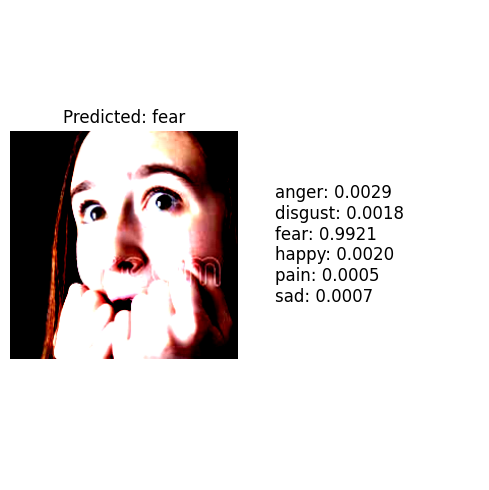

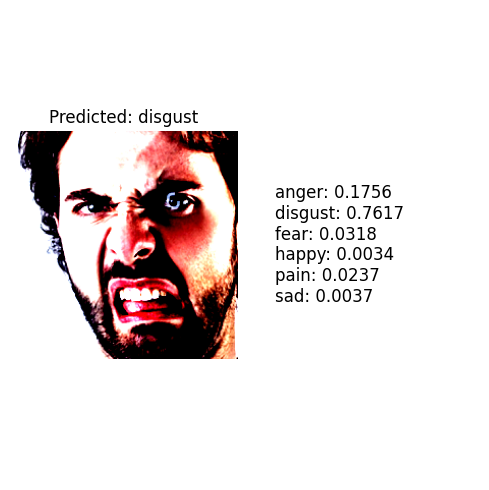

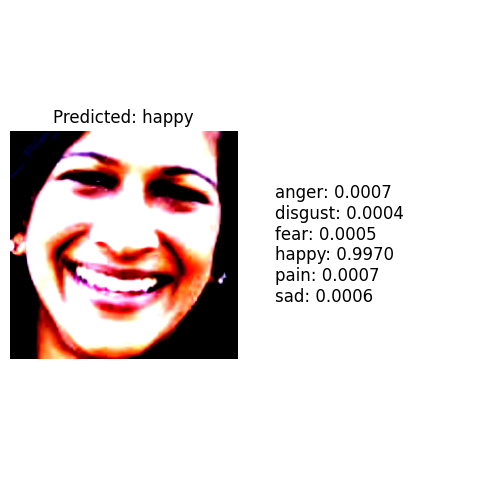

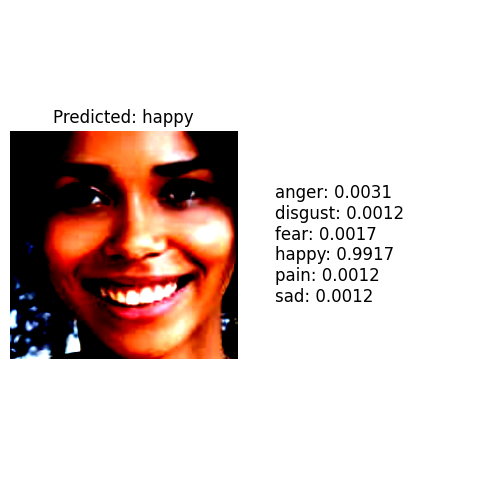

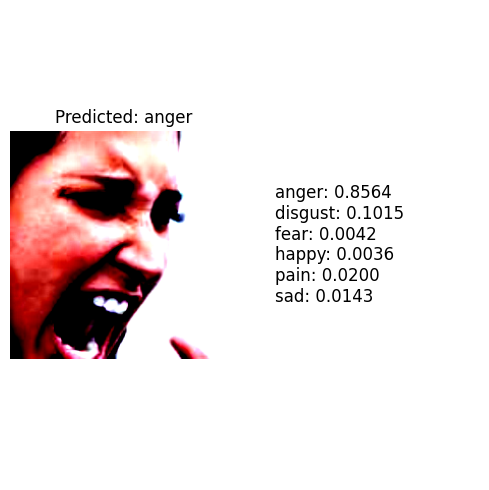

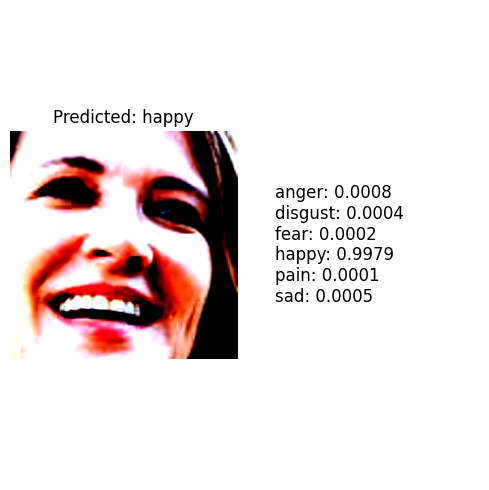

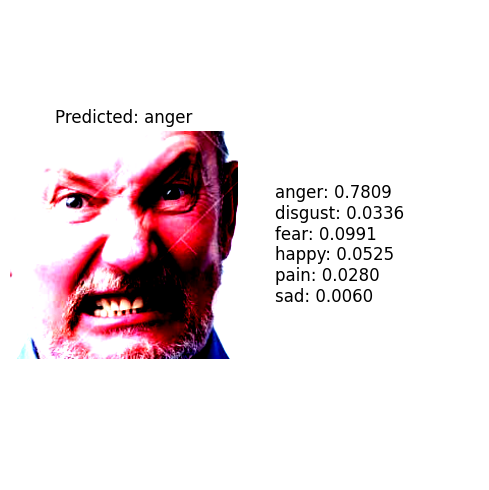

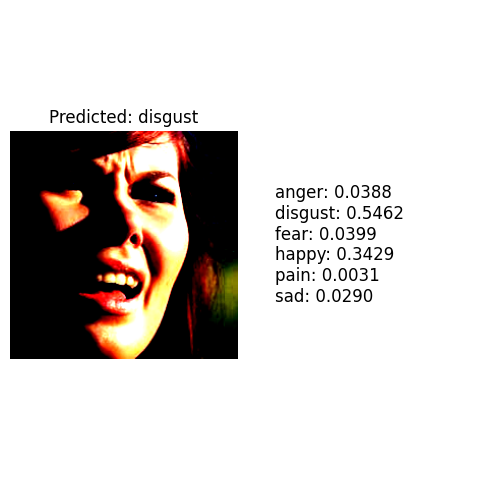

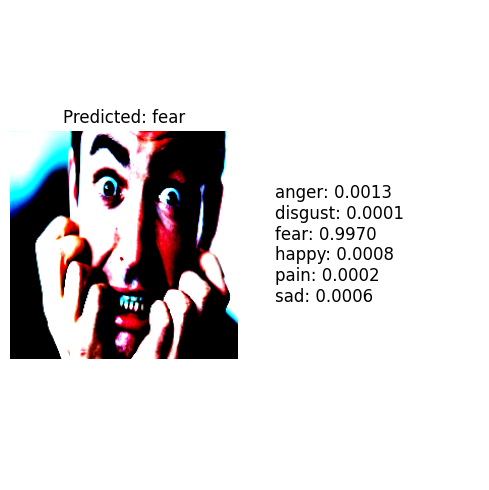

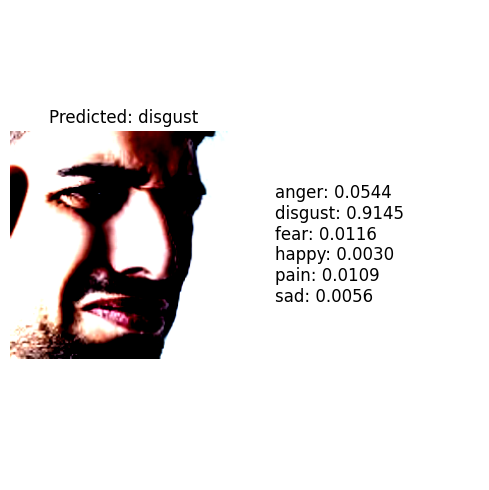

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn.functional as F

def visualize_random_predictions(model, dataloader, class_names, num_images=10):
    model.eval()
    all_inputs = []
    all_labels = []

    for inputs, labels in dataloader:
        for i in range(inputs.size()[0]):
            all_inputs.append(inputs[i])
            all_labels.append(labels[i])

    random_indices = random.sample(range(len(all_inputs)), num_images)
    selected_images = [all_inputs[idx] for idx in random_indices]
    selected_labels = [all_labels[idx] for idx in random_indices]

    with torch.no_grad():
        for i in range(num_images):
            inputs = selected_images[i].unsqueeze(0).to(device)
            labels = selected_labels[i].to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            fig, ax = plt.subplots(1, 2, figsize=(5, 5))
            ax[0].axis('off')
            img = inputs.cpu().squeeze(0).permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            ax[0].imshow(img)
            ax[0].set_title(f'Predicted: {class_names[preds.item()]}')

            prob_text = "\n".join([f"{class_names[j]}: {probs[0][j]:.4f}" for j in range(len(class_names))])
            ax[1].text(0.1, 0.5, prob_text, fontsize=12, verticalalignment='center')
            ax[1].axis('off')

            plt.tight_layout()
            plt.show()

n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)

model_best.load_state_dict(torch.load('RMSprop_model_params.pt'))

visualize_random_predictions(model_best, dataloaders['test'], class_names)


### **5. 선정된 model로 외부 이미지 출력**

In [ ]:
def load_image(image_data, transform=None):
    image = Image.open(io.BytesIO(image_data)).convert('RGB')
    if transform:
        image = transform(image).unsqueeze(0)
    return image

def predict_image(model, image_data, transform, class_names):
    image = load_image(image_data, transform)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    return preds.item(), probs.cpu().numpy()

def visualize_prediction(image_data, pred_class, pred_probs, class_names):
    image = Image.open(io.BytesIO(image_data)).convert('RGB')
    plt.imshow(image)
    plt.title(f'Predicted: {class_names[pred_class]}')
    plt.axis('off')
    plt.show()

    print("Prediction Probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {pred_probs[0][i]:.4f}")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

FileUpload(value={}, accept='image/*', description='Upload')

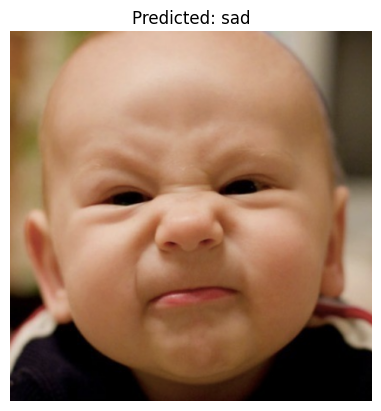

Prediction Probabilities:
anger: 0.0001
disgust: 0.0001
fear: 0.0004
happy: 0.0001
pain: 0.0001
sad: 0.9992


In [ ]:
import io
from ipywidgets import FileUpload
from IPython.display import display

upload_widget = FileUpload(accept='image/*', multiple=False)

n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)

model_best.load_state_dict(torch.load('RMSprop_model_params.pt'))

def on_upload_change(change):
    image_data = next(iter(change['new'].values()))['content']
    pred_class, pred_probs = predict_image(model_best, image_data, transform, class_names)
    visualize_prediction(image_data, pred_class, pred_probs, class_names)

upload_widget.observe(on_upload_change, names='value')

display(upload_widget)


FileUpload(value={}, accept='image/*', description='Upload')

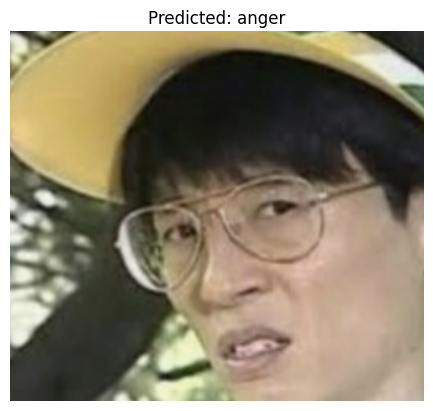

Prediction Probabilities:
anger: 0.3324
disgust: 0.1897
fear: 0.1084
happy: 0.1058
pain: 0.0970
sad: 0.1667


In [ ]:
import io
from ipywidgets import FileUpload
from IPython.display import display

upload_widget = FileUpload(accept='image/*', multiple=False)
n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)

model_best.load_state_dict(torch.load('RMSprop_model_params.pt'))

def on_upload_change(change):
    image_data = next(iter(change['new'].values()))['content']
    pred_class, pred_probs = predict_image(model_best, image_data, transform, class_names)
    visualize_prediction(image_data, pred_class, pred_probs, class_names)

upload_widget.observe(on_upload_change, names='value')

display(upload_widget)

FileUpload(value={}, accept='image/*', description='Upload')

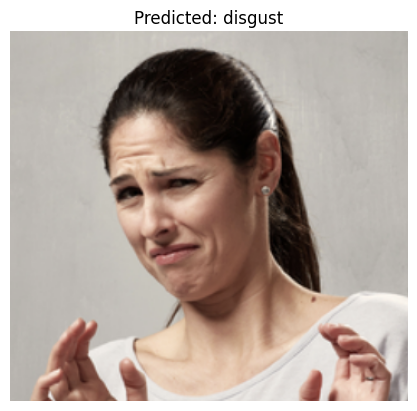

Prediction Probabilities:
anger: 0.2246
disgust: 0.2581
fear: 0.0675
happy: 0.1556
pain: 0.0901
sad: 0.2042


In [ ]:
import io
from ipywidgets import FileUpload
from IPython.display import display

upload_widget = FileUpload(accept='image/*', multiple=False)
n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)

model_best.load_state_dict(torch.load('RMSprop_model_params.pt'))

def on_upload_change(change):
    image_data = next(iter(change['new'].values()))['content']
    pred_class, pred_probs = predict_image(model_best, image_data, transform, class_names)
    visualize_prediction(image_data, pred_class, pred_probs, class_names)

upload_widget.observe(on_upload_change, names='value')

display(upload_widget)

FileUpload(value={}, accept='image/*', description='Upload')

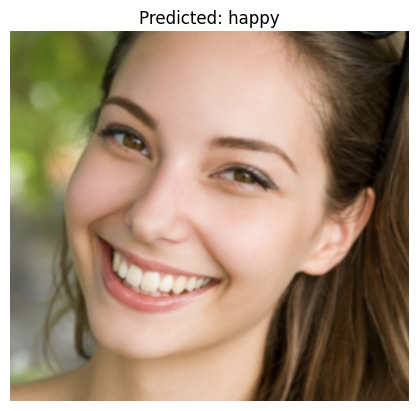

Prediction Probabilities:
anger: 0.1338
disgust: 0.2183
fear: 0.0882
happy: 0.2527
pain: 0.0689
sad: 0.2381


In [ ]:
import io
from ipywidgets import FileUpload
from IPython.display import display

upload_widget = FileUpload(accept='image/*', multiple=False)
n_features = 6
model_best = models.resnet152(pretrained=True)
model_best.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout
    nn.Linear(model_best.fc.in_features, n_features)  # 마지막 fully connected layer
)
model_best.to(device)

model_best.load_state_dict(torch.load('RMSprop_model_params.pt'))

def on_upload_change(change):
    image_data = next(iter(change['new'].values()))['content']
    pred_class, pred_probs = predict_image(model_best, image_data, transform, class_names)
    visualize_prediction(image_data, pred_class, pred_probs, class_names)

upload_widget.observe(on_upload_change, names='value')

display(upload_widget)